In [72]:
import logging
import time
import numpy as np
import matplotlib.pyplot as plt
import tensorflow_datasets as tfds
import tensorflow as tf
import tensorflow_text

In [73]:
import tensorflow_datasets as tfds

# Load the dataset with info and as supervised
examples, metadata = tfds.load('ted_hrlr_translate/pt_to_en', with_info=True, as_supervised=True)

# Get training and validation examples
train_examples, val_examples = examples['train'], examples['validation']


In [74]:
for pt_examples, en_examples in train_examples.batch(3).take(1):
    print('> Examples in Portuguese:')
    for pt in pt_examples.numpy():
         print(pt.decode('utf-8'))
    print()
    print('> Examples in English:')
    for en in en_examples.numpy():
        print(en.decode('utf-8'))

> Examples in Portuguese:
e quando melhoramos a procura , tiramos a única vantagem da impressão , que é a serendipidade .
mas e se estes fatores fossem ativos ?
mas eles não tinham a curiosidade de me testar .

> Examples in English:
and when you improve searchability , you actually take away the one advantage of print , which is serendipity .
but what if it were active ?
but they did n't test for curiosity .


In [75]:
model_name = 'ted_hrlr_translate_pt_en_converter'

tf.keras.utils.get_file(f'{model_name}.zip',
f'https://storage.googleapis.com/download.tensorflow.org/models/{model_name}.zip',
 cache_dir='.', cache_subdir='', extract=True)
tokenizers = tf.saved_model.load(model_name)

In [76]:
[item for item in dir(tokenizers.en) if not item.startswith('_')]


['detokenize',
 'get_reserved_tokens',
 'get_vocab_path',
 'get_vocab_size',
 'lookup',
 'tokenize',
 'tokenizer',
 'vocab']

In [77]:
print('> This is a batch of strings:')
for en in en_examples.numpy():
    print(en.decode('utf-8'))
encoded = tokenizers.en.tokenize(en_examples)
print('> This is a padded-batch of token IDs:')
for row in encoded.to_list():
    print(row)

> This is a batch of strings:
and when you improve searchability , you actually take away the one advantage of print , which is serendipity .
but what if it were active ?
but they did n't test for curiosity .
> This is a padded-batch of token IDs:
[2, 72, 117, 79, 1259, 1491, 2362, 13, 79, 150, 184, 311, 71, 103, 2308, 74, 2679, 13, 148, 80, 55, 4840, 1434, 2423, 540, 15, 3]
[2, 87, 90, 107, 76, 129, 1852, 30, 3]
[2, 87, 83, 149, 50, 9, 56, 664, 85, 2512, 15, 3]


In [78]:
round_trip = tokenizers.en.detokenize(encoded)
print('> This is human-readable text:')
for line in round_trip.numpy():
    print(line.decode('utf-8'))


> This is human-readable text:
and when you improve searchability , you actually take away the one advantage of print , which is serendipity .
but what if it were active ?
but they did n ' t test for curiosity .


In [79]:
print('> This is the text split into tokens:')
tokens = tokenizers.en.lookup(encoded)
tokens

> This is the text split into tokens:


<tf.RaggedTensor [[b'[START]', b'and', b'when', b'you', b'improve', b'search', b'##ability',
  b',', b'you', b'actually', b'take', b'away', b'the', b'one', b'advantage',
  b'of', b'print', b',', b'which', b'is', b's', b'##ere', b'##nd', b'##ip',
  b'##ity', b'.', b'[END]']                                                 ,
 [b'[START]', b'but', b'what', b'if', b'it', b'were', b'active', b'?',
  b'[END]']                                                           ,
 [b'[START]', b'but', b'they', b'did', b'n', b"'", b't', b'test', b'for',
  b'curiosity', b'.', b'[END]']                                          ]>

...................................................

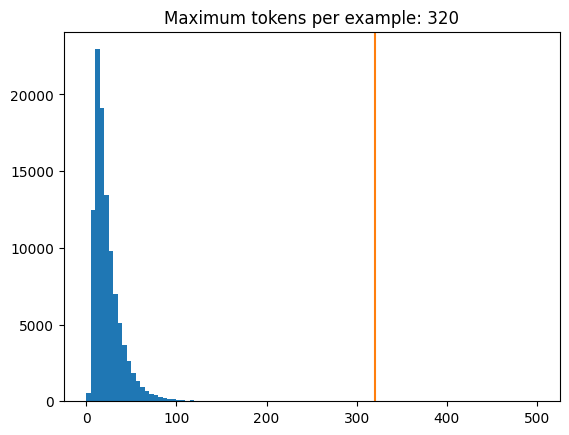

In [80]:
lengths = []
for pt_examples, en_examples in train_examples.batch(1024):
    pt_tokens = tokenizers.pt.tokenize(pt_examples)
    lengths.append(pt_tokens.row_lengths())
    en_tokens = tokenizers.en.tokenize(en_examples)
    lengths.append(en_tokens.row_lengths())
    print('.', end='', flush=True)

    all_lengths = np.concatenate(lengths)

plt.hist(all_lengths, np.linspace(0, 500, 101))
plt.ylim(plt.ylim())
max_length = max(all_lengths)
plt.plot([max_length, max_length], plt.ylim())
plt.title(f'Maximum tokens per example: {max_length}');

In [122]:
MAX_TOKENS=128
def prepare_batch(pt, en):
    pt = tokenizers.pt.tokenize(pt) # Output is ragged.
    pt = pt[:, :MAX_TOKENS] # Trim to MAX_TOKENS.
    pt = pt.to_tensor() # Convert to 0-padded dense Tensor
    en = tokenizers.en.tokenize(en)
    en = en[:, :(MAX_TOKENS+1)]
    en_inputs = en[:, :MAX_TOKENS].to_tensor() # Drop the [END] tokens
    en_labels = en[:, 1:(MAX_TOKENS + 1)].to_tensor() #TODO # Drop the [START] tokens
    return (pt, en_inputs), en_labels


In [123]:
BUFFER_SIZE = 20000
BATCH_SIZE = 64
def make_batches(ds):
    return (ds
            .shuffle(BUFFER_SIZE)
             .batch(BATCH_SIZE)
             .map(prepare_batch, tf.data.AUTOTUNE)
             .prefetch(buffer_size=tf.data.AUTOTUNE))

In [124]:
# Create training and validation set batches.
train_batches = make_batches(train_examples)
val_batches = make_batches(val_examples)


In [125]:
for (pt, en), en_labels in train_batches.take(1):
    break
print(pt.shape)
print(en.shape)
print(en_labels.shape)


(64, 89)
(64, 93)
(64, 92)


In [126]:
def positional_encoding(length, depth):
    depth = depth // 2
    positions = np.arange(length)[:, np.newaxis]  # (seq, 1)
    depths = np.arange(depth)[np.newaxis, :] / depth  # (1, depth)
    angle_rates = 1 / (10000 ** depths)  # (1, depth)
    angle_rads = positions * angle_rates  # (seq, depth)
    # Apply sine to even indices in the depth dimension
    angle_rads[:, 0::2] = np.sin(angle_rads[:, 0::2])
    # Apply cosine to odd indices in the depth dimension
    angle_rads[:, 1::2] = np.cos(angle_rads[:, 1::2])
    pos_encoding = angle_rads[np.newaxis, ...]  # Add batch dimension
    return tf.cast(pos_encoding, dtype=tf.float32)

# Test positional encoding
max_len = 50
embedding_dim = 512
pos_encoding = positional_encoding(max_len, embedding_dim)
print(pos_encoding.shape)  # Output shape should be (1, max_len, embedding_dim)

(1, 50, 256)


(2048, 256)


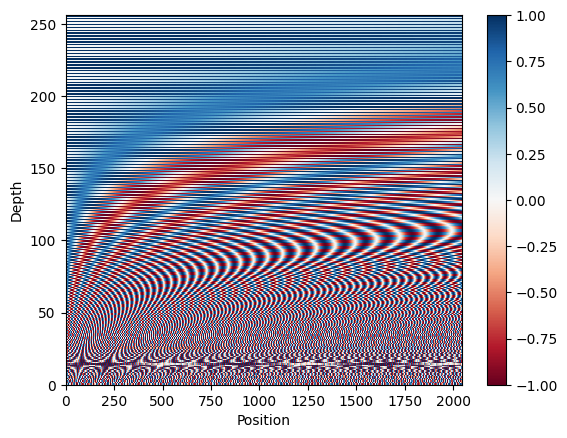

In [127]:
pos_encoding = positional_encoding(length=2048, depth=512)
# Reshape the positional encoding tensor
pos_encoding = np.squeeze(pos_encoding, axis=0)
# Check the shape.
print(pos_encoding.shape)
# Plot the dimensions.
plt.pcolormesh(pos_encoding.T, cmap='RdBu')
plt.ylabel('Depth')
plt.xlabel('Position')
plt.colorbar()
plt.show()


(0.0, 1.0)

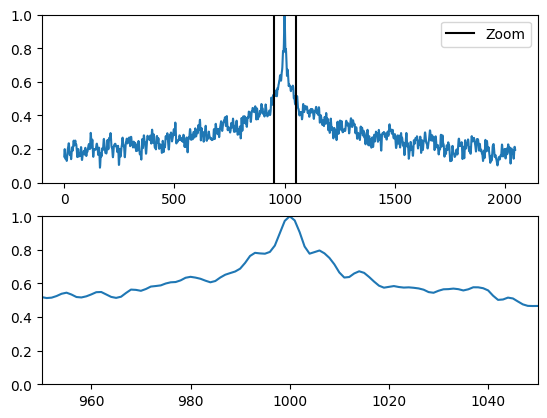

In [128]:
#@title
pos_encoding/=tf.norm(pos_encoding, axis=1, keepdims=True)
p = pos_encoding[1000]
dots = tf.einsum('pd,d -> p', pos_encoding, p)
plt.subplot(2,1,1)
plt.plot(dots)
plt.ylim([0,1])
plt.plot([950, 950, float('nan'), 1050, 1050],
 [0,1,float('nan'),0,1], color='k', label='Zoom')
plt.legend()
plt.subplot(2,1,2)
plt.plot(dots)
plt.xlim([950, 1050])
plt.ylim([0,1])


In [129]:
class PositionalEmbedding(tf.keras.layers.Layer):
    def __init__(self, vocab_size, d_model):
        super().__init__()
        self.d_model = d_model
        self.embedding = tf.keras.layers.Embedding(vocab_size, d_model)
        self.pos_encoding = positional_encoding(length=2048, depth=2 * d_model)
    def compute_mask(self, *args, **kwargs):
         return self.embedding.compute_mask(*args, **kwargs)
    def call(self, inputs):
        length = tf.shape(inputs)[1]
        x = self.embedding(inputs)
        print("Shape of embedding:", x.shape)
        x *= tf.math.sqrt(tf.cast(self.d_model, tf.float32))
        # Adjust positional encoding shape to match the input sequence length
        pos_encoding = self.pos_encoding[:, :length, :]
        print("Shape of positional encoding:", pos_encoding.shape)
        x = x + pos_encoding
        return x

In [130]:
# Assuming the vocabulary sizes for Portuguese and English
vocab_size_pt = 10000  
vocab_size_en = 15000  

# Initialize positional embeddings for Portuguese and English
embed_pt = PositionalEmbedding(vocab_size=vocab_size_pt, d_model=512)
embed_en = PositionalEmbedding(vocab_size=vocab_size_en, d_model=512)

# Cast the input sequences to int64 data type
pt = tf.cast(pt, dtype=tf.int64)
en = tf.cast(en, dtype=tf.int64)

# Apply positional embeddings to input sequences
pt_emb = embed_pt(pt)
en_emb = embed_en(en)

# Access masking information from en_emb
mask = embed_en.compute_mask(en)  # Using compute_mask method


Shape of embedding: (64, 89, 512)
Shape of positional encoding: (1, 89, 512)
Shape of embedding: (64, 89, 512)
Shape of positional encoding: (1, 89, 512)
Shape of embedding: (64, 93, 512)
Shape of positional encoding: (1, 93, 512)
Shape of embedding: (64, 93, 512)
Shape of positional encoding: (1, 93, 512)


In [131]:
class BaseAttention(tf.keras.layers.Layer):
    def __init__(self, **kwargs):
        super().__init__()
        self.mha = tf.keras.layers.MultiHeadAttention(**kwargs)
        self.layernorm = tf.keras.layers.LayerNormalization(epsilon=1e-6) #Normalization
        self.add = tf.keras.layers.Add()


In [132]:
class CrossAttention(BaseAttention):
    def call(self, x, context):
        attn_output, attn_scores = self.mha(
        query=x,
        key=context,
        value=context,
        return_attention_scores=True)
        # Cache the attention scores for plotting later.
        self.last_attn_scores = attn_scores
        x = self.add([x, attn_output]) 
        x = self.layernorm(x)
        return x


In [133]:
sample_ca = CrossAttention(num_heads=2, key_dim=512)
print(pt_emb.shape)
print(en_emb.shape)
print(sample_ca(en_emb, pt_emb).shape)


(64, 89, 512)
(64, 93, 512)
(64, 93, 512)


In [134]:
class GlobalSelfAttention(BaseAttention):
    def call(self, x):
        attn_output = self.mha(
        query=x,
        value=x,
        key=x)
        x = self.add([x, attn_output]) 
        x = self.layernorm(x)
        return x
sample_gsa = GlobalSelfAttention(num_heads=2, key_dim=512)
print(pt_emb.shape)
print(sample_gsa(pt_emb).shape)


(64, 89, 512)
(64, 89, 512)


In [135]:
class CausalSelfAttention(BaseAttention):
    def call(self, x):
        attn_output = self.mha(
         query=x,
         value=x,
         key=x,
         use_causal_mask = True)
        x = self.add([x, attn_output])
        x = self.layernorm(x)
        return x

In [136]:
sample_csa = CausalSelfAttention(num_heads=2, key_dim=512)
print(en_emb.shape)
print(sample_csa(en_emb).shape)


(64, 93, 512)
(64, 93, 512)


In [137]:
out1 = sample_csa(embed_en(en[:, :3]))
out2 = sample_csa(embed_en(en))[:, :3]
tf.reduce_max(abs(out1 - out2)).numpy()


Shape of embedding: (64, 3, 512)
Shape of positional encoding: (1, 3, 512)
Shape of embedding: (64, 93, 512)
Shape of positional encoding: (1, 93, 512)


4.7683716e-07

In [138]:
class FeedForward(tf.keras.layers.Layer):
    def __init__(self, d_model, dff, dropout_rate=0.1):
        super().__init__()
        self.seq = tf.keras.Sequential([
         tf.keras.layers.Dense(dff, activation='relu'),
         tf.keras.layers.Dense(d_model),
         tf.keras.layers.Dropout(dropout_rate)
         ])
        self.add = tf.keras.layers.Add()
        self.layer_norm = tf.keras.layers.LayerNormalization()
    def call(self, x):
        x = self.add([x, self.seq(x)])
        x = self.layer_norm(x)
        return x


In [139]:
sample_ffn = FeedForward(512, 2048)
print(en_emb.shape)
print(sample_ffn(en_emb).shape)

(64, 93, 512)
(64, 93, 512)


In [140]:
class EncoderLayer(tf.keras.layers.Layer):
    def __init__(self,*, d_model, num_heads, dff, dropout_rate=0.1):
        super().__init__()
        self.self_attention = GlobalSelfAttention(
        num_heads=num_heads,
        key_dim=d_model,
        dropout=dropout_rate)
        self.ffn = FeedForward(d_model, dff)
    def call(self, x):
        x = self.self_attention(x)
        x = self.ffn(x)
        return x

In [141]:
# Create an instance of EncoderLayer
sample_encoder_layer = EncoderLayer(d_model=512, num_heads=8, dff=2048)


print("Shape of pt_emb:", pt_emb.shape)
print("Shape after passing through the encoder layer:", sample_encoder_layer(pt_emb).shape)

Shape of pt_emb: (64, 89, 512)
Shape after passing through the encoder layer: (64, 89, 512)


In [142]:
class Encoder(tf.keras.layers.Layer):
    def __init__(self, *, num_layers, d_model, num_heads,
               dff, vocab_size, dropout_rate=0.1):
        super().__init__()

        self.d_model = d_model
        self.num_layers = num_layers

        self.pos_embedding = PositionalEmbedding(vocab_size=vocab_size, d_model=d_model)

        self.enc_layers = [EncoderLayer(d_model=d_model,
                                        num_heads=num_heads,
                                        dff=dff,
                                        dropout_rate=dropout_rate)
                                        for _ in range(num_layers)]
        self.dropout = tf.keras.layers.Dropout(dropout_rate)

    def call(self, x):
    # `x` is token-IDs shape: (batch, seq_len)
        x = self.pos_embedding(x) # Shape `(batch_size, seq_len, d_model)`.

    # Add dropout.
        x = self.dropout(x)

        for i in range(self.num_layers):
              x = self.enc_layers[i](x)
        return x

In [143]:
# Instantiate the encoder
num_layers = 4
d_model = 512
num_heads = 8
dff = 2048
vocab_size = 10000  # Example vocabulary size
dropout_rate = 0.1

encoder = Encoder(num_layers=num_layers,
                  d_model=d_model,
                  num_heads=num_heads,
                  dff=dff,
                  vocab_size=vocab_size,
                  dropout_rate=dropout_rate)

# Generate some sample input data
batch_size = 64
max_seq_length = 100
input_data = tf.random.uniform((batch_size, max_seq_length), dtype=tf.int32, maxval=vocab_size)

# Pass the input data through the encoder
output = encoder(input_data)

# Check the shape of the output
print("Shape of input data:", input_data.shape)
print("Shape of encoder output:", output.shape)


Shape of embedding: (64, 100, 512)
Shape of positional encoding: (1, 100, 512)
Shape of embedding: (64, 100, 512)
Shape of positional encoding: (1, 100, 512)
Shape of embedding: (64, 100, 512)
Shape of positional encoding: (1, 100, 512)
Shape of input data: (64, 100)
Shape of encoder output: (64, 100, 512)


In [144]:
class DecoderLayer(tf.keras.layers.Layer):
    def __init__(self, *, d_model, num_heads, dff, dropout_rate=0.1):
        super().__init__()
        self.causal_self_attention = CausalSelfAttention(
            num_heads=num_heads,
            key_dim=d_model,
            dropout=dropout_rate
        )
        self.cross_attention = CrossAttention(
            num_heads=num_heads,
            key_dim=d_model,
            dropout=dropout_rate
        )
        self.ffn = self.create_ffn(d_model, dff, dropout_rate)

    def call(self, x, context):
        x = self.causal_self_attention(x)
        x = self.cross_attention(x, context)
        # Cache the last attention scores for plotting later
        self.last_attn_scores = self.cross_attention.last_attn_scores
        x = self.ffn(x)  # Shape `(batch_size, seq_len, d_model)`.
        return x
    def create_ffn(self, d_model, dff, dropout_rate):
        return tf.keras.Sequential([
            tf.keras.layers.Dense(dff, activation='relu'),
            tf.keras.layers.Dropout(dropout_rate),
            tf.keras.layers.Dense(d_model)
        ])

In [145]:
sample_decoder_layer = DecoderLayer(d_model=512, num_heads=8, dff=2048)
sample_decoder_layer_output = sample_decoder_layer(x=en_emb, context=pt_emb)


print("Shape of en_emb:", en_emb.shape)
print("Shape of pt_emb:", pt_emb.shape)
print("Shape of sample_decoder_layer_output:", sample_decoder_layer_output.shape)  # `(batch_size, seq_len, d_model)`


Shape of en_emb: (64, 93, 512)
Shape of pt_emb: (64, 89, 512)
Shape of sample_decoder_layer_output: (64, 93, 512)


In [146]:
class Decoder(tf.keras.layers.Layer):
    def __init__(self, *, num_layers, d_model, num_heads, dff, vocab_size,dropout_rate=0.1):
        super(Decoder, self).__init__()
        self.d_model = d_model
        self.num_layers = num_layers
        self.pos_embedding = PositionalEmbedding(vocab_size=vocab_size,d_model=d_model)
        self.dropout = tf.keras.layers.Dropout(dropout_rate)
        self.dec_layers = [DecoderLayer(d_model=d_model, num_heads=num_heads,
        dff=dff, dropout_rate=dropout_rate)
        for _ in range(num_layers)]
        self.last_attn_scores = None
    def call(self, x, context):
        # `x` is token-IDs shape (batch, target_seq_len)
        x = self.pos_embedding(x) # (batch_size, target_seq_len, d_model)
        x = self.dropout(x)
        for i in range(self.num_layers):
             x = self.dec_layers[i](x, context)
             self.last_attn_scores = self.dec_layers[i].last_attn_scores #Use .last_attn_scores appropriately
             # The shape of x is (batch_size, target_seq_len, d_model).
        return x

In [147]:
# Instantiate the decoder.
sample_decoder = Decoder(num_layers=4,
 d_model=512,
num_heads=8,
dff=2048,
vocab_size=8000)
output = sample_decoder(en, context=pt_emb)
# Print the shapes.
print(en.shape)
print(pt_emb.shape)
print(output.shape)
sample_decoder.last_attn_scores.shape # (batch, heads, target_seq, input_seq)


Shape of embedding: (64, 93, 512)
Shape of positional encoding: (1, 93, 512)
Shape of embedding: (64, 93, 512)
Shape of positional encoding: (1, 93, 512)
Shape of embedding: (64, 93, 512)
Shape of positional encoding: (1, 93, 512)
(64, 93)
(64, 89, 512)
(64, 93, 512)


TensorShape([64, 8, 93, 89])

In [148]:
class Transformer(tf.keras.Model):
    def __init__(self, *, num_layers, d_model, num_heads, dff,input_vocab_size, target_vocab_size, dropout_rate=0.1):
        super().__init__()
        self.encoder = Encoder(num_layers=num_layers, d_model=d_model,
                               num_heads=num_heads, dff=dff,
                               vocab_size=input_vocab_size,
                               dropout_rate=dropout_rate)
        self.decoder = Decoder(num_layers=num_layers, d_model=d_model,
                               num_heads=num_heads, dff=dff,
                               vocab_size=target_vocab_size,
                               dropout_rate=dropout_rate)
        self.final_layer = tf.keras.layers.Dense(target_vocab_size)
    def call(self, inputs):
     # To use a Keras model with `.fit` you must pass all your inputs in the
         # first argument.
        context, x = inputs
        context = self.encoder(context) # (batch_size, context_len,d_model)
        x = self.decoder(x, context) # (batch_size, target_len, d_model)
         # Final linear layer output.
        logits = self.final_layer(x) # (batch_size, target_len,target_vocab_size)
        try:
         # Drop the keras mask, so it doesn't scale the losses/metrics.
         # b/250038731
             del logits._keras_mask
        except AttributeError:
             pass
         # Return the final output and the attention weights.
        return logits

In [149]:
num_layers = 4 
d_model = 128 
dff = 512 
num_heads = 8 
dropout_rate = 0.1


In [150]:
transformer = Transformer(
    num_layers=num_layers,
    d_model=d_model,
    num_heads=num_heads,
    dff=dff,
    input_vocab_size=tokenizers.pt.get_vocab_size().numpy(),
    target_vocab_size=tokenizers.en.get_vocab_size().numpy(),
    dropout_rate=dropout_rate)


In [151]:
output = transformer((pt, en))
print(en.shape)
print(pt.shape)
print(output.shape)
attn_scores = transformer.decoder.dec_layers[-1].last_attn_scores
print(attn_scores.shape) # (batch, heads, target_seq, input_seq)

Shape of embedding: (64, 89, 128)
Shape of positional encoding: (1, 89, 128)
Shape of embedding: (64, 89, 128)
Shape of positional encoding: (1, 89, 128)
Shape of embedding: (64, 89, 128)
Shape of positional encoding: (1, 89, 128)
Shape of embedding: (64, 93, 128)
Shape of positional encoding: (1, 93, 128)
Shape of embedding: (64, 93, 128)
Shape of positional encoding: (1, 93, 128)
Shape of embedding: (64, 93, 128)
Shape of positional encoding: (1, 93, 128)
Shape of embedding: (64, 89, 128)
Shape of positional encoding: (1, 89, 128)
Shape of embedding: (64, 93, 128)
Shape of positional encoding: (1, 93, 128)
(64, 93)
(64, 89)
(64, 93, 7010)
(64, 8, 93, 89)


In [152]:
class CustomSchedule(tf.keras.optimizers.schedules.LearningRateSchedule):
    def __init__(self, d_model, warmup_steps=4000):
        super().__init__()
        self.d_model = d_model
        self.d_model = tf.cast(self.d_model, tf.float32)
        self.warmup_steps = warmup_steps
    def __call__(self, step):
        step = tf.cast(step, dtype=tf.float32)
        arg1 = tf.math.rsqrt(step)
        arg2 = step * (self.warmup_steps ** -1.5)
        return tf.math.rsqrt(self.d_model) * tf.math.minimum(arg1, arg2)
learning_rate = CustomSchedule(d_model)
optimizer = tf.optimizers.Adam(learning_rate, beta_1=0.9, beta_2=0.98, epsilon=1e-9)


Text(0.5, 0, 'Train Step')

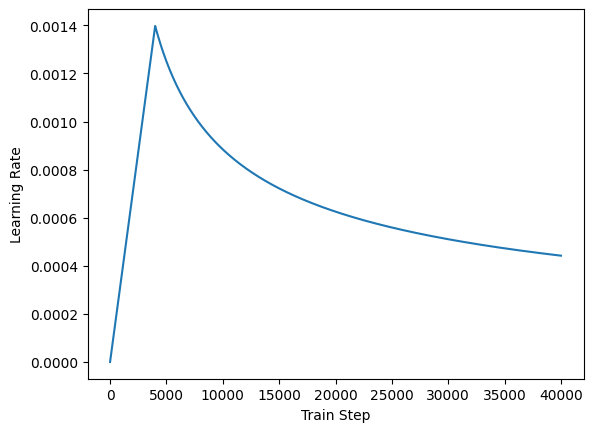

In [153]:
plt.plot(learning_rate(tf.range(40000, dtype=tf.float32)))
plt.ylabel('Learning Rate')
plt.xlabel('Train Step')


In [154]:
 def masked_loss(label, pred):
    mask = label != 0
    loss_object = tf.keras.losses.SparseCategoricalCrossentropy(
    from_logits=True, reduction='none')
    loss = loss_object(label, pred)
    mask = tf.cast(mask, dtype=loss.dtype)
    loss *= mask
    loss = tf.reduce_sum(loss)/tf.reduce_sum(mask)
    return loss


In [155]:
def masked_accuracy(label, pred):
    pred = tf.argmax(pred, axis=2)
    label = tf.cast(label, pred.dtype)
    match = label == pred
    mask = label != 0
    match = match & mask
    match = tf.cast(match, dtype=tf.float32)
    mask = tf.cast(mask, dtype=tf.float32)
    return tf.reduce_sum(match)/tf.reduce_sum(mask)

In [156]:
transformer.compile( loss=masked_loss, optimizer=optimizer, metrics=[masked_accuracy])


In [163]:
transformer.fit(train_batches, epochs=1, validation_data=val_batches)

InvalidArgumentError: Graph execution error:

Detected at node compile_loss/masked_loss/sparse_categorical_crossentropy/SparseSoftmaxCrossEntropyWithLogits/assert_equal_1/Assert/Assert defined at (most recent call last):
  File "/opt/conda/lib/python3.10/runpy.py", line 196, in _run_module_as_main

  File "/opt/conda/lib/python3.10/runpy.py", line 86, in _run_code

  File "/opt/conda/lib/python3.10/site-packages/ipykernel_launcher.py", line 17, in <module>

  File "/opt/conda/lib/python3.10/site-packages/traitlets/config/application.py", line 1043, in launch_instance

  File "/opt/conda/lib/python3.10/site-packages/ipykernel/kernelapp.py", line 701, in start

  File "/opt/conda/lib/python3.10/site-packages/tornado/platform/asyncio.py", line 195, in start

  File "/opt/conda/lib/python3.10/asyncio/base_events.py", line 603, in run_forever

  File "/opt/conda/lib/python3.10/asyncio/base_events.py", line 1909, in _run_once

  File "/opt/conda/lib/python3.10/asyncio/events.py", line 80, in _run

  File "/opt/conda/lib/python3.10/site-packages/ipykernel/kernelbase.py", line 534, in dispatch_queue

  File "/opt/conda/lib/python3.10/site-packages/ipykernel/kernelbase.py", line 523, in process_one

  File "/opt/conda/lib/python3.10/site-packages/ipykernel/kernelbase.py", line 429, in dispatch_shell

  File "/opt/conda/lib/python3.10/site-packages/ipykernel/kernelbase.py", line 767, in execute_request

  File "/opt/conda/lib/python3.10/site-packages/ipykernel/ipkernel.py", line 429, in do_execute

  File "/opt/conda/lib/python3.10/site-packages/ipykernel/zmqshell.py", line 549, in run_cell

  File "/opt/conda/lib/python3.10/site-packages/IPython/core/interactiveshell.py", line 3051, in run_cell

  File "/opt/conda/lib/python3.10/site-packages/IPython/core/interactiveshell.py", line 3106, in _run_cell

  File "/opt/conda/lib/python3.10/site-packages/IPython/core/async_helpers.py", line 129, in _pseudo_sync_runner

  File "/opt/conda/lib/python3.10/site-packages/IPython/core/interactiveshell.py", line 3311, in run_cell_async

  File "/opt/conda/lib/python3.10/site-packages/IPython/core/interactiveshell.py", line 3493, in run_ast_nodes

  File "/opt/conda/lib/python3.10/site-packages/IPython/core/interactiveshell.py", line 3553, in run_code

  File "/tmp/ipykernel_33/87014310.py", line 1, in <module>

  File "/opt/conda/lib/python3.10/site-packages/keras/src/utils/traceback_utils.py", line 118, in error_handler

  File "/opt/conda/lib/python3.10/site-packages/keras/src/backend/tensorflow/trainer.py", line 323, in fit

  File "/opt/conda/lib/python3.10/site-packages/keras/src/backend/tensorflow/trainer.py", line 117, in one_step_on_iterator

  File "/opt/conda/lib/python3.10/site-packages/keras/src/backend/tensorflow/trainer.py", line 105, in one_step_on_data

  File "/opt/conda/lib/python3.10/site-packages/keras/src/backend/tensorflow/trainer.py", line 59, in train_step

  File "/opt/conda/lib/python3.10/site-packages/keras/src/trainers/trainer.py", line 321, in compute_loss

  File "/opt/conda/lib/python3.10/site-packages/keras/src/trainers/compile_utils.py", line 606, in __call__

  File "/opt/conda/lib/python3.10/site-packages/keras/src/trainers/compile_utils.py", line 642, in call

  File "/opt/conda/lib/python3.10/site-packages/keras/src/losses/loss.py", line 43, in __call__

  File "/opt/conda/lib/python3.10/site-packages/keras/src/losses/losses.py", line 22, in call

  File "/tmp/ipykernel_33/3369495383.py", line 5, in masked_loss

  File "/opt/conda/lib/python3.10/site-packages/keras/src/losses/loss.py", line 43, in __call__

  File "/opt/conda/lib/python3.10/site-packages/keras/src/losses/losses.py", line 22, in call

  File "/opt/conda/lib/python3.10/site-packages/keras/src/losses/losses.py", line 1714, in sparse_categorical_crossentropy

  File "/opt/conda/lib/python3.10/site-packages/keras/src/ops/nn.py", line 1541, in sparse_categorical_crossentropy

  File "/opt/conda/lib/python3.10/site-packages/keras/src/backend/tensorflow/nn.py", line 633, in sparse_categorical_crossentropy

assertion failed: [Condition x == y did not hold element-wise:] [x (compile_loss/masked_loss/sparse_categorical_crossentropy/SparseSoftmaxCrossEntropyWithLogits/Shape_1:0) = ] [64 122] [y (compile_loss/masked_loss/sparse_categorical_crossentropy/SparseSoftmaxCrossEntropyWithLogits/strided_slice:0) = ] [64 123]
	 [[{{node compile_loss/masked_loss/sparse_categorical_crossentropy/SparseSoftmaxCrossEntropyWithLogits/assert_equal_1/Assert/Assert}}]] [Op:__inference_one_step_on_iterator_187811]

In [159]:
class Translator(tf.Module):
    def __init__(self, tokenizers, transformer):
        self.tokenizers = tokenizers
        self.transformer = transformer
    def __call__(self, sentence, max_length=MAX_TOKENS):
     # The input sentence is Portuguese, hence adding the `[START]` and `[END]` tokens.
        assert isinstance(sentence, tf.Tensor)
        if len(sentence.shape) == 0:
            sentence = sentence[tf.newaxis]
        sentence = self.tokenizers.pt.tokenize(sentence).to_tensor()
        encoder_input = sentence
         # As the output language is English, initialize the output with the
         # English `[START]` token.
        start_end = self.tokenizers.en.tokenize([''])[0]
        start = start_end[0][tf.newaxis]
        end = start_end[1][tf.newaxis]
        # `tf.TensorArray`is required here (instead of a Python list), so that the
        # dynamic-loop can be traced by `tf.function`.
        output_array = tf.TensorArray(dtype=tf.int64, size=0, dynamic_size=True)
        output_array = output_array.write(0, start)
        for i in tf.range(max_length):
            output = tf.transpose(output_array.stack())
            predictions = self.transformer([encoder_input, output],training=False)
     # Select the last token from the `seq_len` dimension.
            predictions = predictions[:, -1:, :] # Shape `(batch_size, 1,vocab_size)`.
            predicted_id = tf.argmax(predictions, axis=-1)
     # Concatenate the `predicted_id` to the output which is given to the
    # decoder as its input.
            output_array = output_array.write(i+1, predicted_id[0])
            if predicted_id == end:
                break
        output = tf.transpose(output_array.stack())
        # The output shape is `(1, tokens)`.
        text = tokenizers.en.detokenize(output)[0] # Shape: `()`.
        tokens = tokenizers.en.lookup(output)[0]
        # `tf.function` prevents us from using the attention_weights that were
        # calculated on the last iteration of the loop.
        # So, recalculate them outside the loop.
        self.transformer([encoder_input, output[:,:-1]], training=False)
        attention_weights = self.transformer.decoder.last_attn_scores
        return text, tokens, attention_weights
    

In [160]:
def print_translation(sentence, tokens, ground_truth):
    print(f'{"Input:":15s}: {sentence}')
    print(f'{"Prediction":15s}: {tokens.numpy().decode("utf-8")}')
    print(f'{"Ground truth":15s}: {ground_truth}')

In [162]:
sentence = 'este é um problema que temos que resolver.'
ground_truth = 'this is a problem we have to solve .'
translated_text, translated_tokens, attention_weights = Translator( tf.constant(sentence))
print_translation(sentence, translated_text, ground_truth)


TypeError: Translator.__init__() missing 1 required positional argument: 'transformer'